In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import scipy.stats as st
import math
import datetime 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn import model_selection
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from mlxtend.regressor import StackingCVRegressor

from scipy.stats import norm, skew
from sklearn import metrics
from collections import Counter

from termcolor import colored
# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

#to see model hyperparameters
from sklearn import set_config
set_config(print_changed_only = False)

# to show all columns
pd.set_option('display.max_columns', 15)

## 1.Read Dataset

In [152]:
data = pd.read_csv("Cardetails.csv")

## 2. Data set overview


In [153]:
data.describe()

,year,selling_price,km_driven,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,5.416719
std,4.044249,8.062534e+05,5.655055e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


In [154]:
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


- Convert values of the columns and change dtypes


In [155]:
#make dtypes of some variables 'category'

categoric_columns = ["fuel", "transmission", "owner", "seller_type"]
for column in categoric_columns:
    data[column] = data[column].astype("category")

In [156]:
#create 'car_brand_name' feature from 'name' feature

data["car_brand_name"] = data["name"].str.extract('([^\s]+)')
data["car_brand_name"] = data["car_brand_name"].astype("category")

In [157]:
#extract values of 'engine' and 'mileage' variables

data["engine"] = data["engine"].str.extract('([^\s]+)').astype("float")
data["mileage"] = data["mileage"].str.extract('([^\s]+)').astype("float")

In [158]:
#extract values of 'max_power' variable

data["max_power"] = data["max_power"].str.extract('([^\s]+)')
data["max_power"] = data["max_power"][~(data["max_power"] == "bhp")]
data["max_power"] = data["max_power"].astype("float")

In [159]:
#create 'car_age' feature from 'year' column

data["car_age"] = (datetime.datetime.now().year) - (data["year"])

In [160]:
data.drop(["name", "year", "torque"], axis = 1, inplace = True)

In [161]:
data.head().style.background_gradient(cmap = "summer")

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,car_brand_name,car_age
0,450000,145500,Diesel,Individual,Manual,First Owner,23.400000,1248.000000,74.000000,5.000000,Maruti,10
1,370000,120000,Diesel,Individual,Manual,Second Owner,21.140000,1498.000000,103.520000,5.000000,Skoda,10
2,158000,140000,Petrol,Individual,Manual,Third Owner,17.700000,1497.000000,78.000000,5.000000,Honda,18
3,225000,127000,Diesel,Individual,Manual,First Owner,23.000000,1396.000000,90.000000,5.000000,Hyundai,14
4,130000,120000,Petrol,Individual,Manual,First Owner,16.100000,1298.000000,88.200000,5.000000,Maruti,17


In [162]:
data.isnull().sum()

selling_price       0
km_driven           0
fuel                0
seller_type         0
transmission        0
owner               0
mileage           221
engine            221
max_power         216
seats             221
car_brand_name      0
car_age             0
dtype: int64

In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   selling_price   8128 non-null   int64   
 1   km_driven       8128 non-null   int64   
 2   fuel            8128 non-null   category
 3   seller_type     8128 non-null   category
 4   transmission    8128 non-null   category
 5   owner           8128 non-null   category
 6   mileage         7907 non-null   float64 
 7   engine          7907 non-null   float64 
 8   max_power       7912 non-null   float64 
 9   seats           7907 non-null   float64 
 10  car_brand_name  8128 non-null   category
 11  car_age         8128 non-null   int64   
dtypes: category(5), float64(4), int64(3)
memory usage: 486.3 KB


In [164]:
data.describe(include = "category").T

,count,unique,top,freq
fuel,8128,4,Diesel,4402
seller_type,8128,3,Individual,6766
transmission,8128,2,Manual,7078
owner,8128,5,First Owner,5289
car_brand_name,8128,32,Maruti,2448


* # Visualize missing values and fill them

<Figure size 1000x500 with 0 Axes>

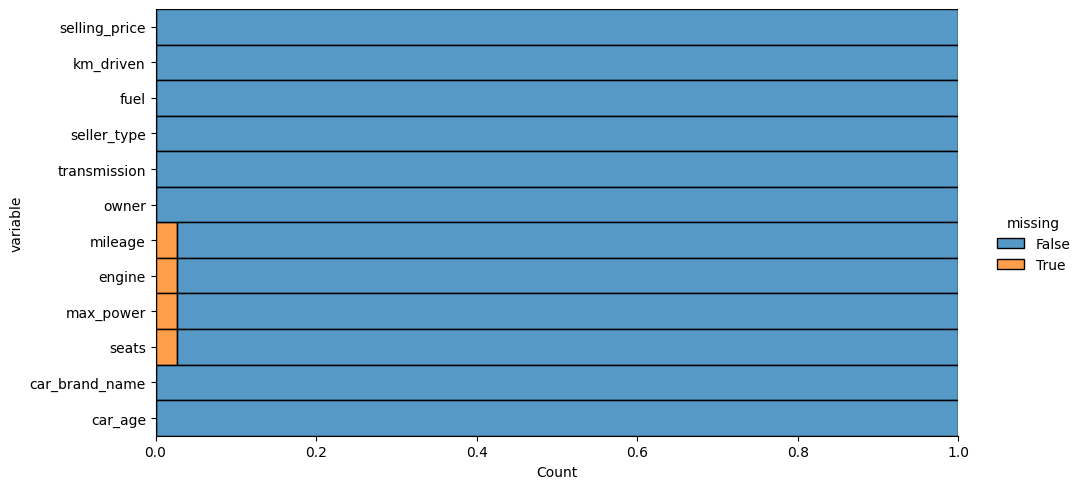

In [165]:
plt.figure(figsize = (10, 5))
sns.displot(
    data = data.isna().melt(value_name = "missing"),
    y = "variable",
    hue = "missing",
    multiple = "fill",
    aspect = 2
);

In [166]:
#check null values again

data.isnull().sum().sum()

879

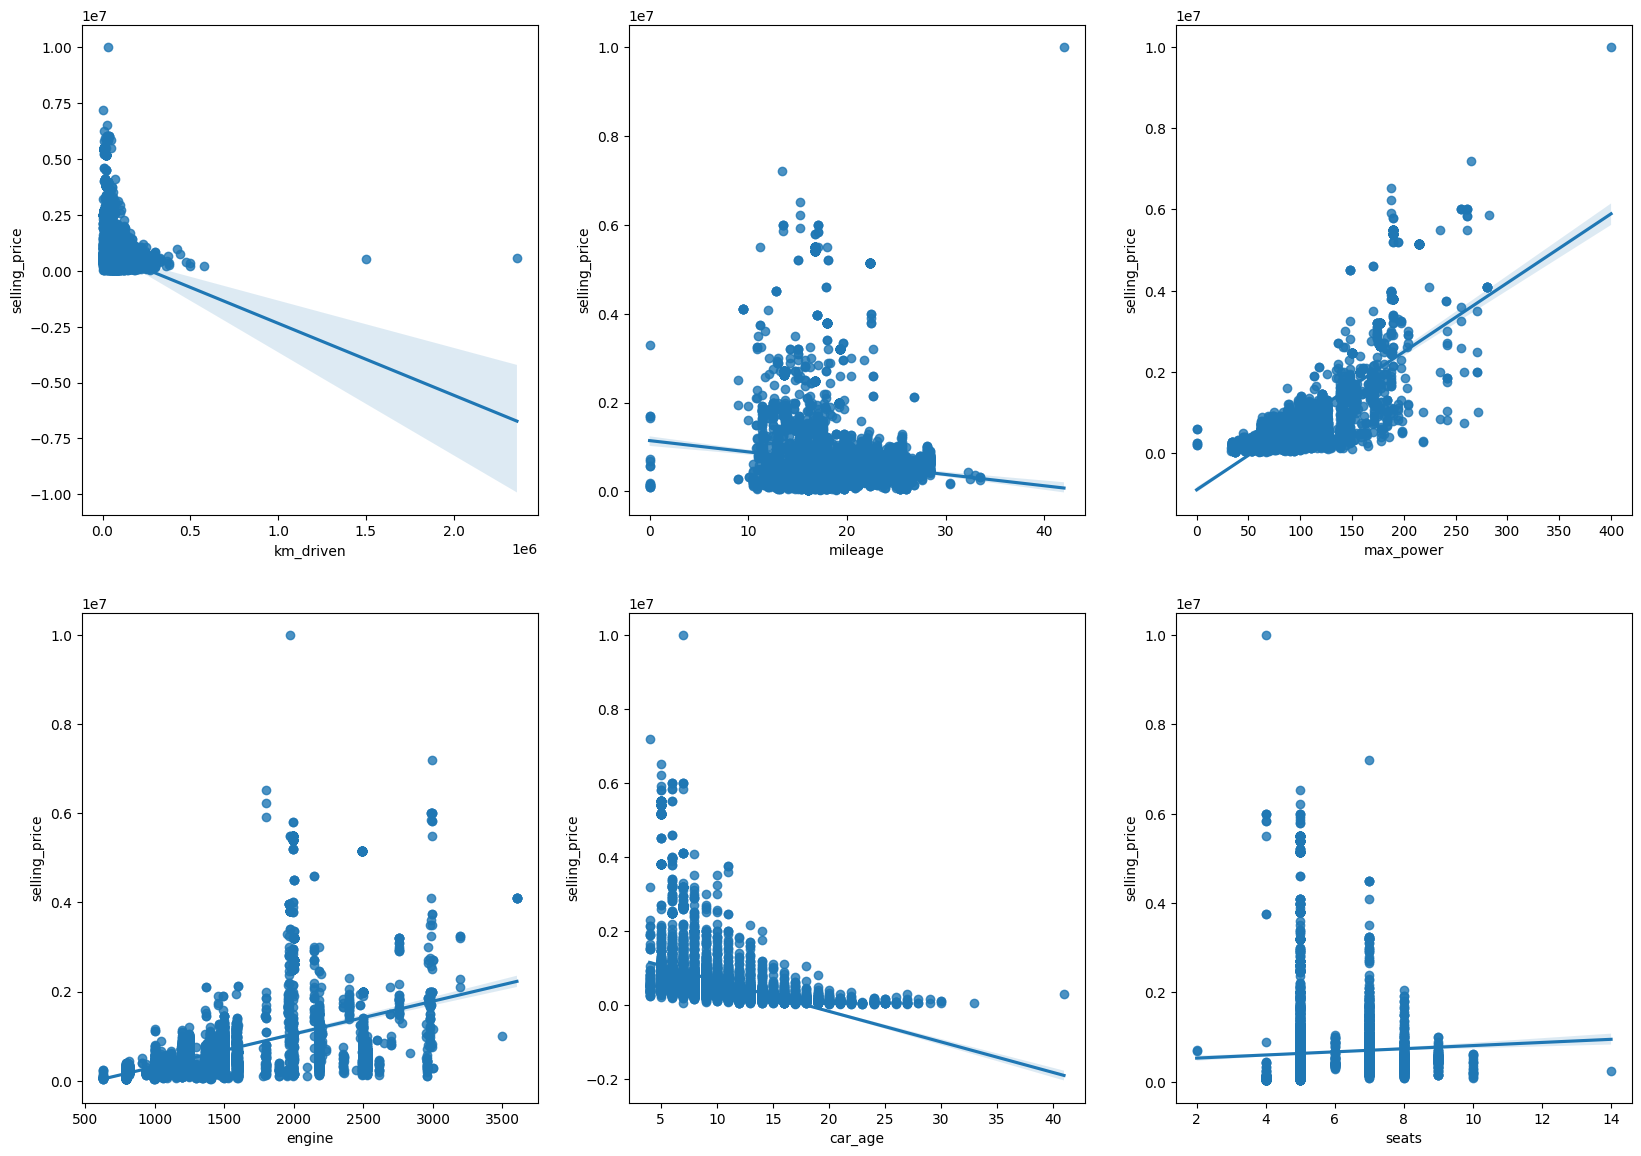

In [167]:
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.flatten()

sns.regplot(ax = axes[0], x = "km_driven", y = "selling_price", data = data);
sns.regplot(ax = axes[1], x = "mileage", y = "selling_price", data = data);
sns.regplot(ax = axes[2], x = "max_power", y = "selling_price", data = data);
sns.regplot(ax = axes[3], x = "engine", y = "selling_price", data = data);
sns.regplot(ax = axes[4], x = "car_age", y = "selling_price", data = data);
sns.regplot(ax = axes[5], x = "seats", y = "selling_price", data = data);

## 3.Data Preparation

In [168]:
data.fuel.unique()

['Diesel', 'Petrol', 'LPG', 'CNG']
Categories (4, object): ['CNG', 'Diesel', 'LPG', 'Petrol']

In [169]:
data_new = pd.get_dummies(data=data, columns=['fuel'], drop_first=True, dtype=int)

In [170]:
data_new.head()

,selling_price,km_driven,seller_type,transmission,owner,mileage,engine,max_power,seats,car_brand_name,car_age,fuel_Diesel,fuel_LPG,fuel_Petrol
0,450000,145500,Individual,Manual,First Owner,23.40,1248.0,74.00,5.0,Maruti,10,1,0,0
1,370000,120000,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0,Skoda,10,1,0,0
2,158000,140000,Individual,Manual,Third Owner,17.70,1497.0,78.00,5.0,Honda,18,0,0,1
3,225000,127000,Individual,Manual,First Owner,23.00,1396.0,90.00,5.0,Hyundai,14,1,0,0
4,130000,120000,Individual,Manual,First Owner,16.10,1298.0,88.20,5.0,Maruti,17,0,0,1


In [171]:
data_new['transmission'] = data_new['transmission'].replace({'Automatic': 1, 'Manual': 0})
data_new.head()

,selling_price,km_driven,seller_type,transmission,owner,mileage,engine,max_power,seats,car_brand_name,car_age,fuel_Diesel,fuel_LPG,fuel_Petrol
0,450000,145500,Individual,0,First Owner,23.40,1248.0,74.00,5.0,Maruti,10,1,0,0
1,370000,120000,Individual,0,Second Owner,21.14,1498.0,103.52,5.0,Skoda,10,1,0,0
2,158000,140000,Individual,0,Third Owner,17.70,1497.0,78.00,5.0,Honda,18,0,0,1
3,225000,127000,Individual,0,First Owner,23.00,1396.0,90.00,5.0,Hyundai,14,1,0,0
4,130000,120000,Individual,0,First Owner,16.10,1298.0,88.20,5.0,Maruti,17,0,0,1


## 4.EDA

- 4.1 Bot Plot

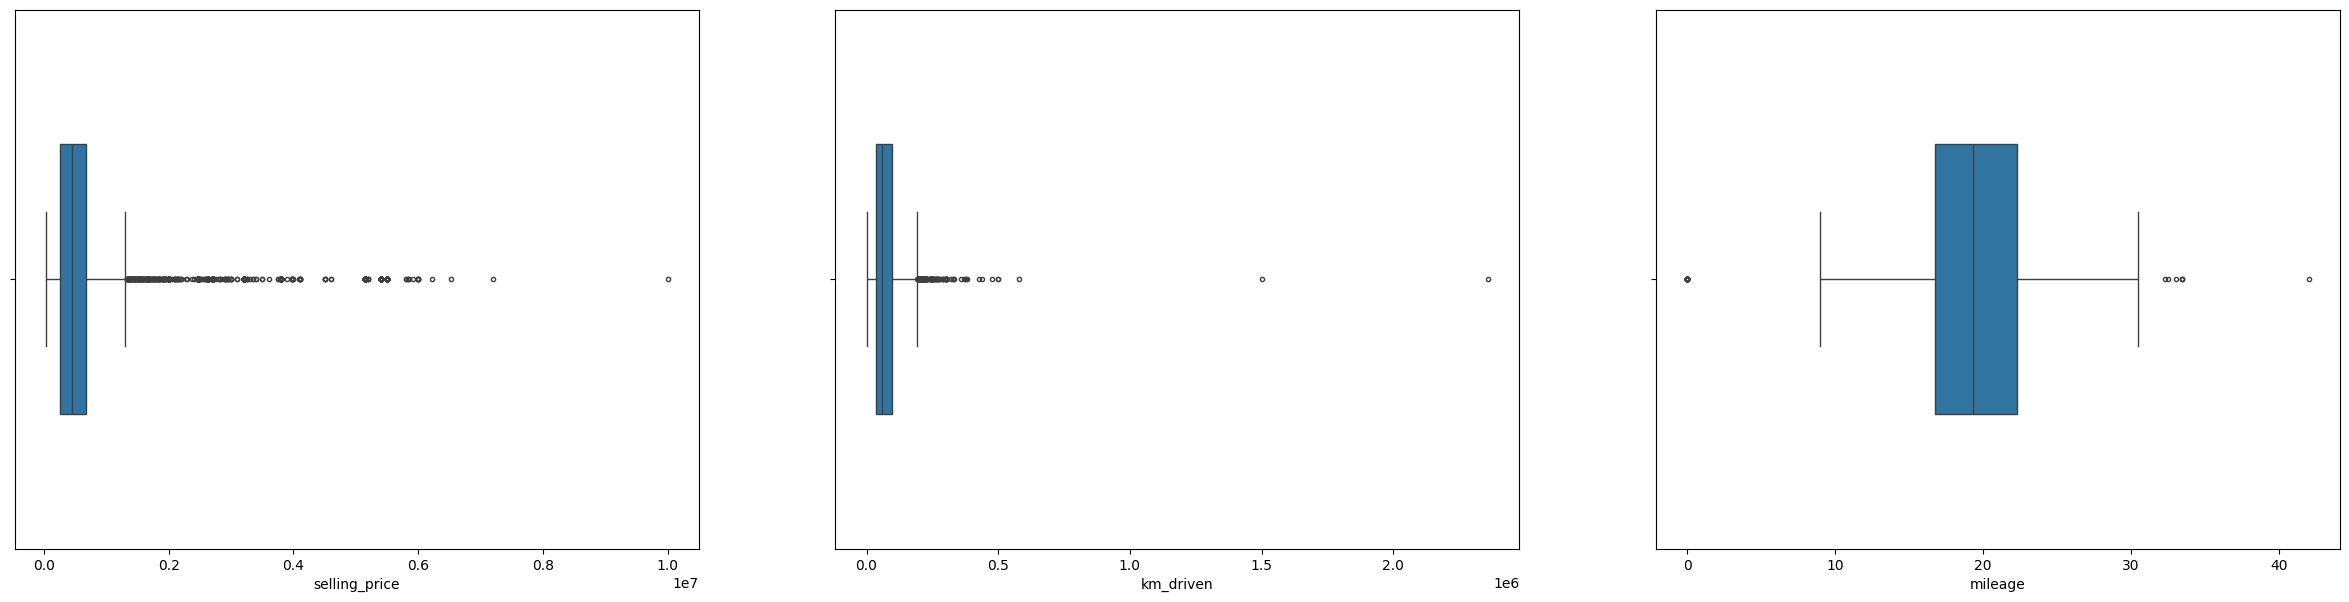

In [172]:
fig, axes = plt.subplots(1, 3, figsize = (30, 7))

sns.boxplot(ax = axes[0], x = "selling_price", data = data, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[1], x = "km_driven", data = data, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[2], x = "mileage", data = data, width = 0.5, fliersize = 3, linewidth = 1);

- Histogram

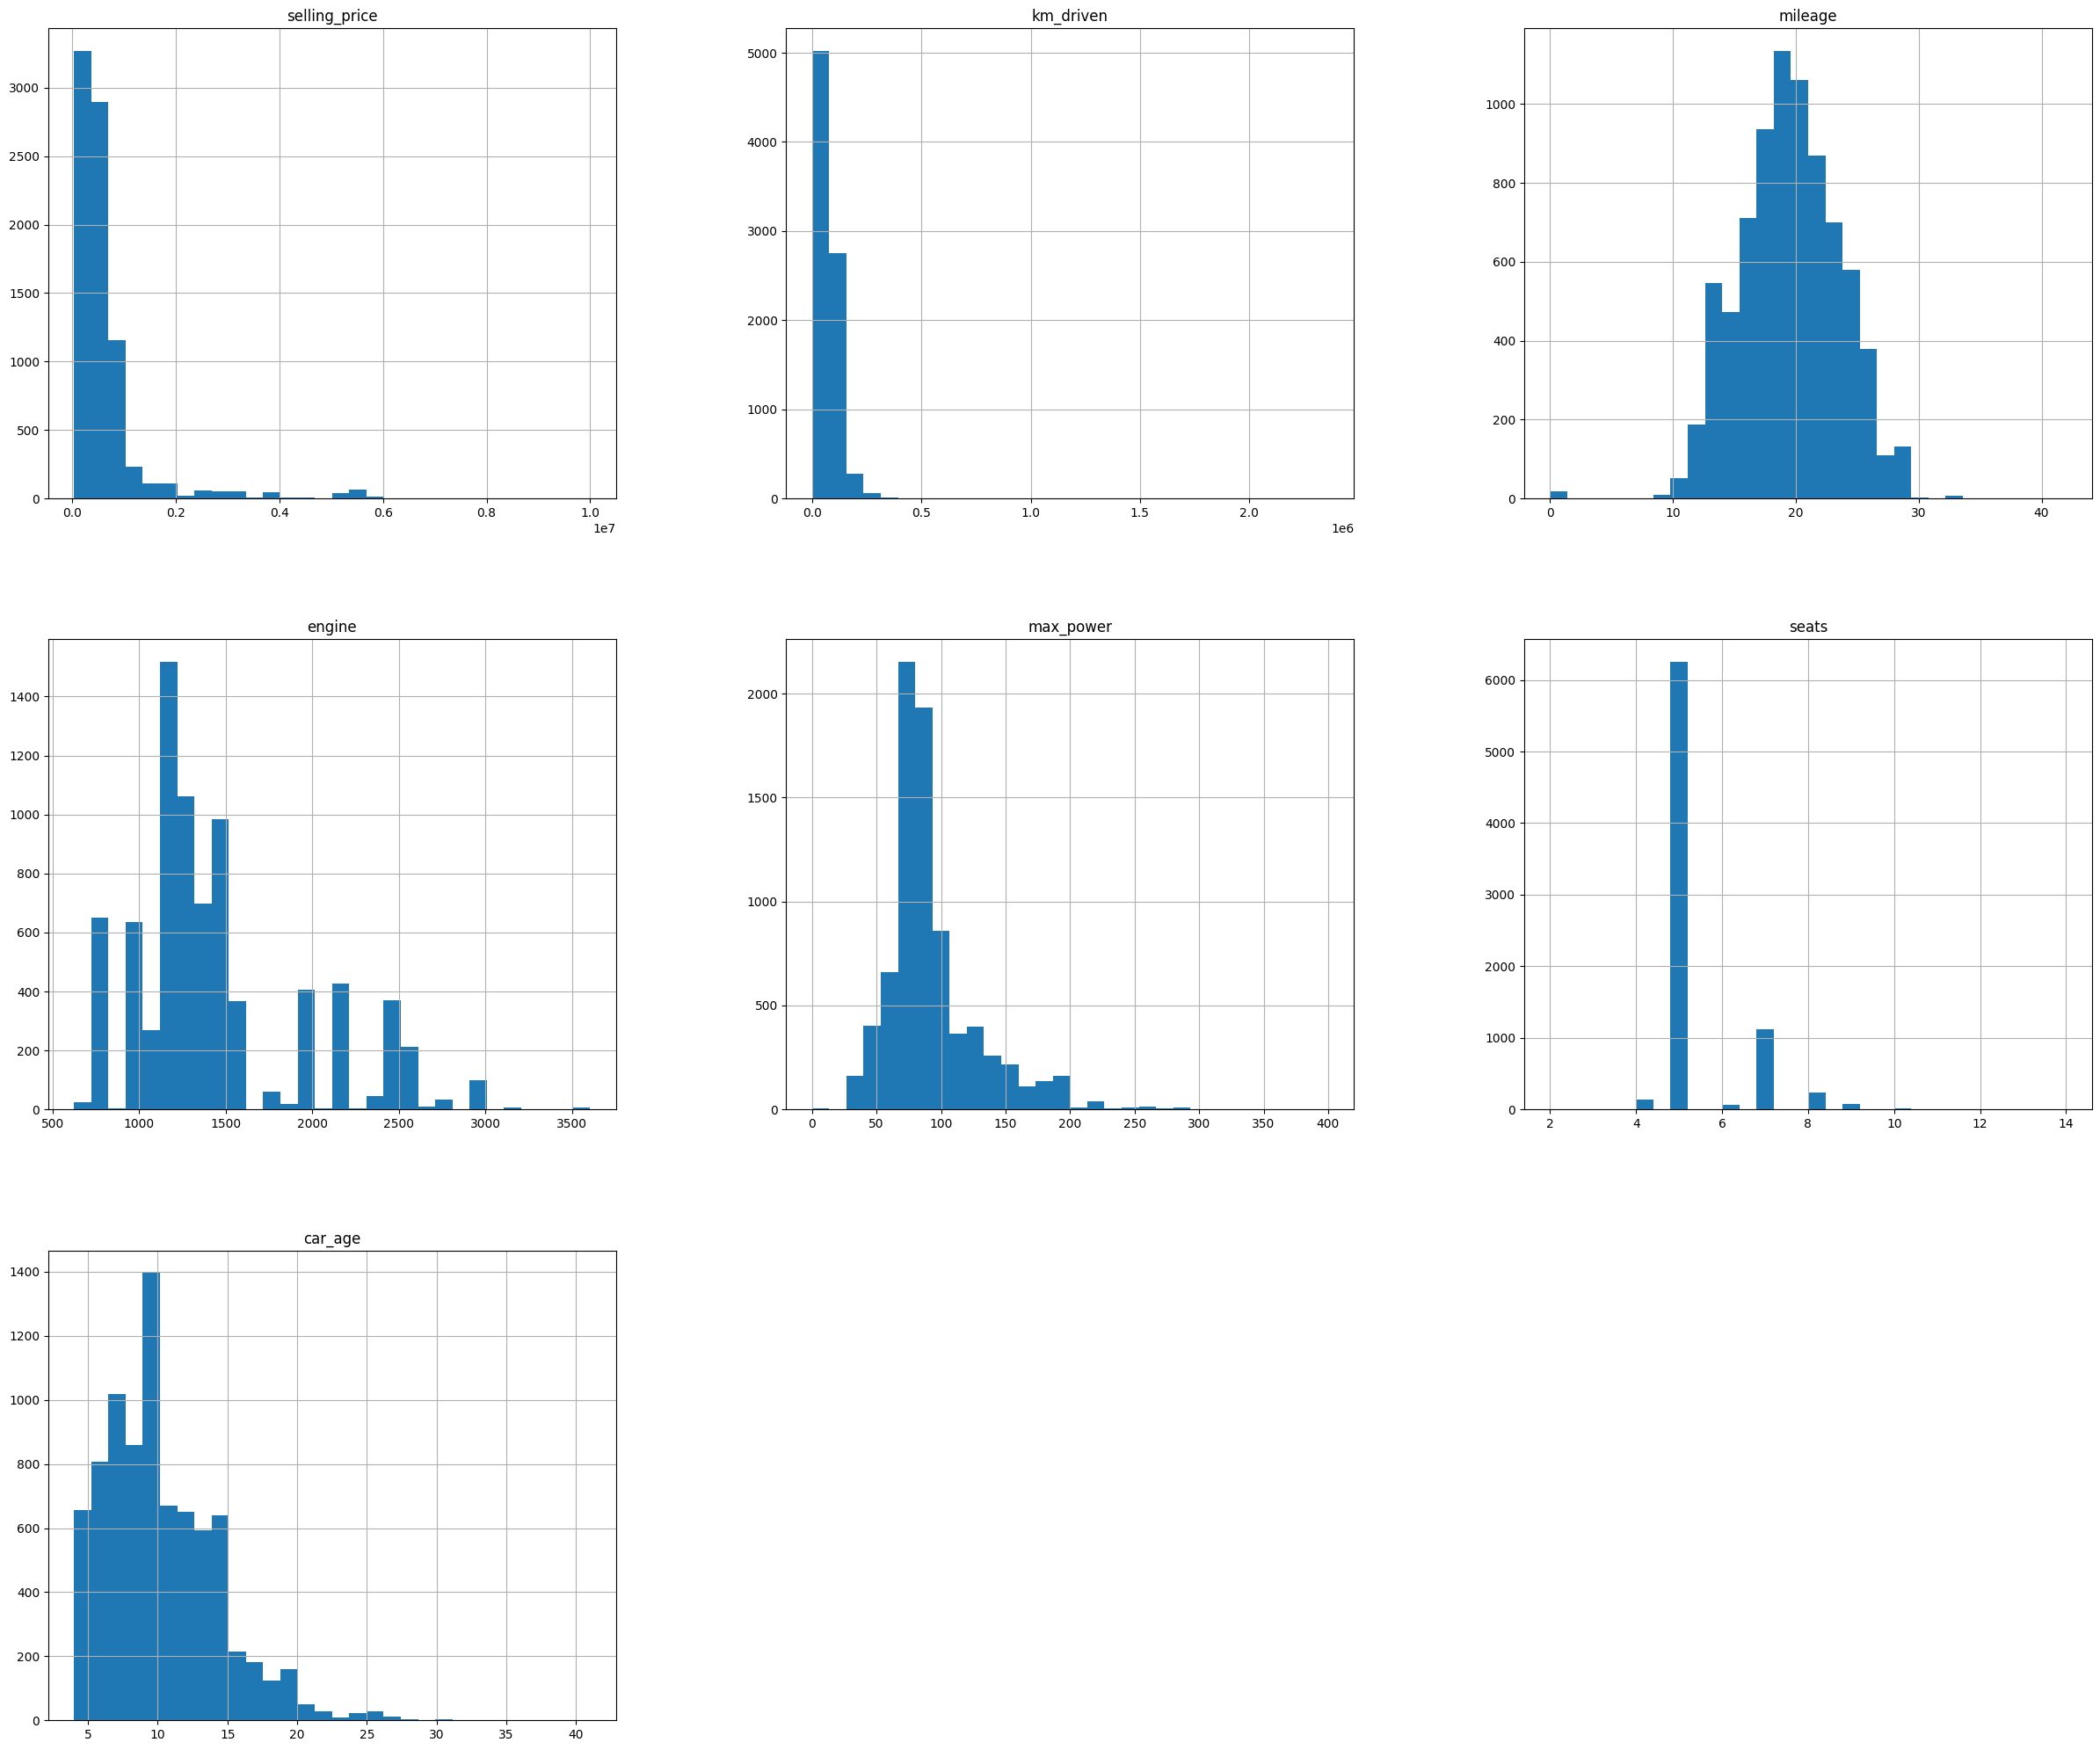

In [173]:
data.hist(figsize = (30, 25), bins = 30, legend = False)
plt.show()

- Scatterplot

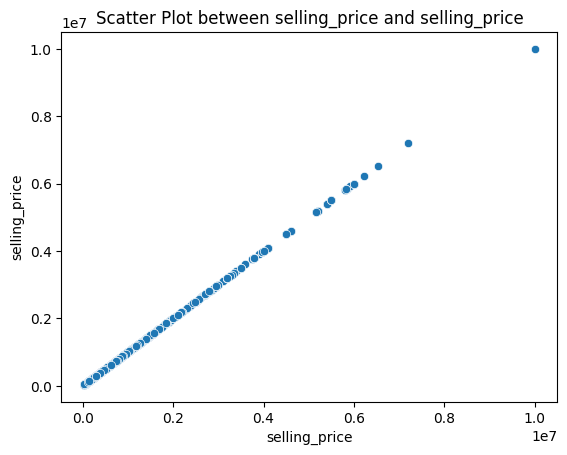

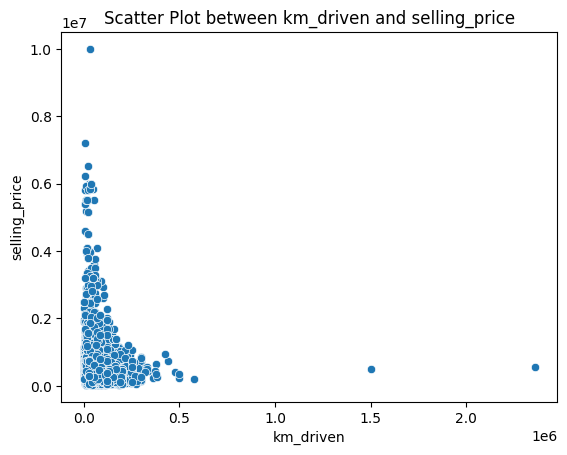

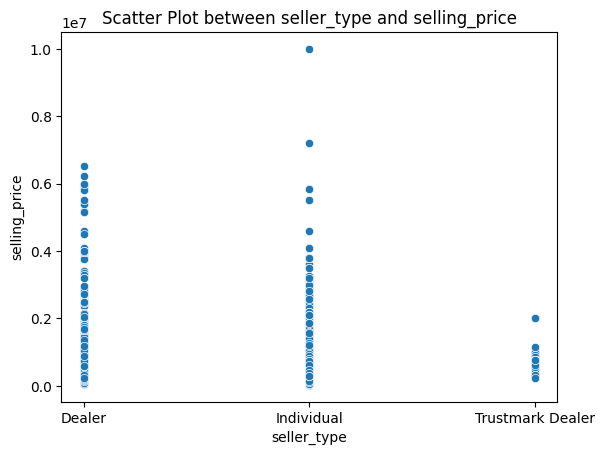

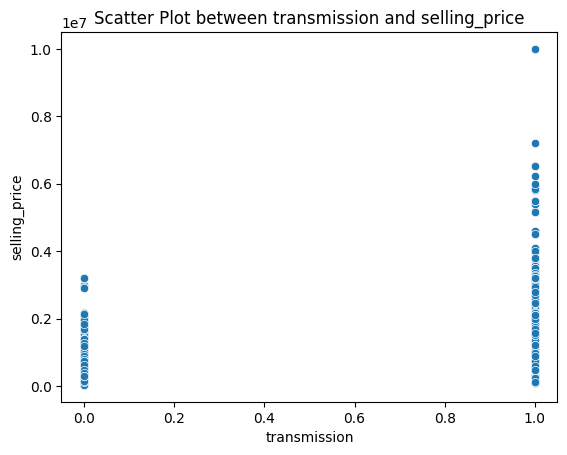

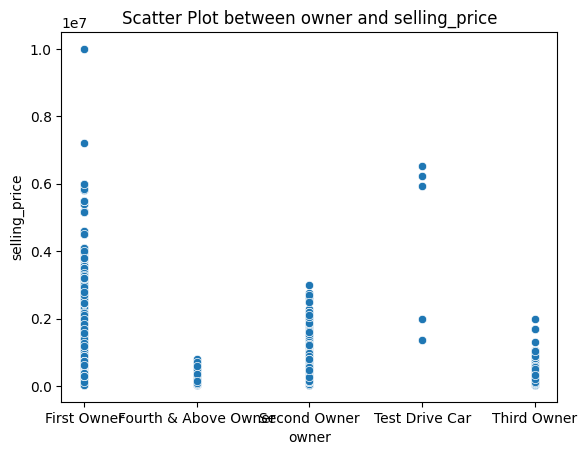

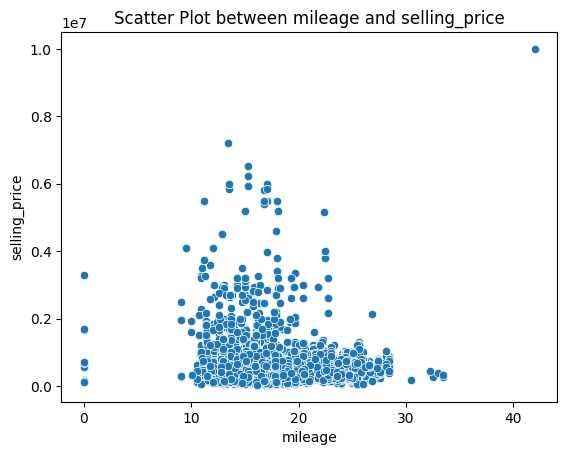

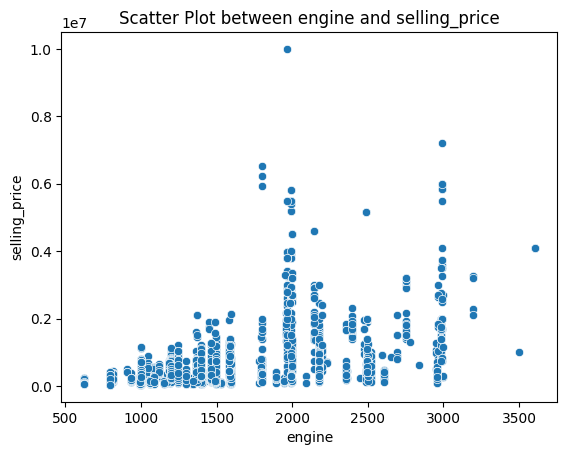

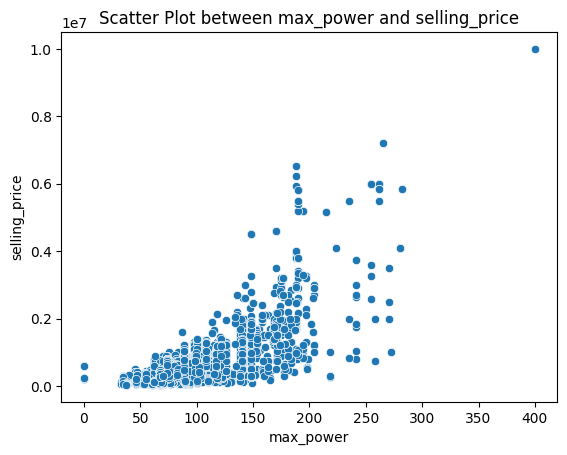

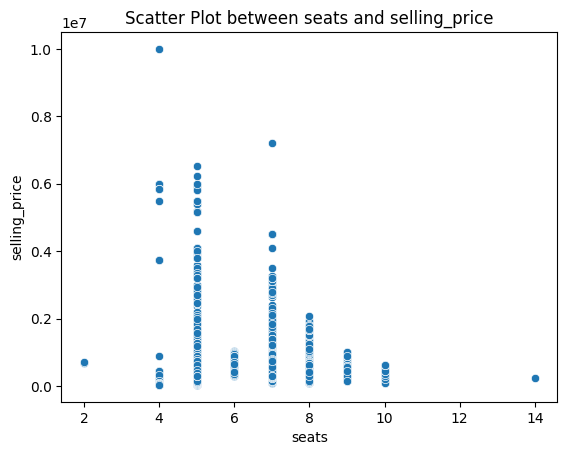

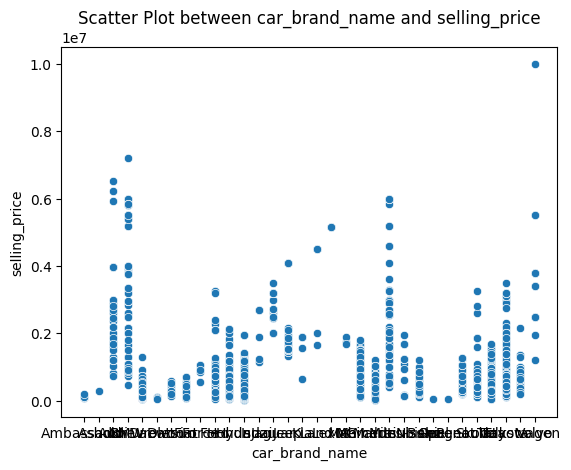

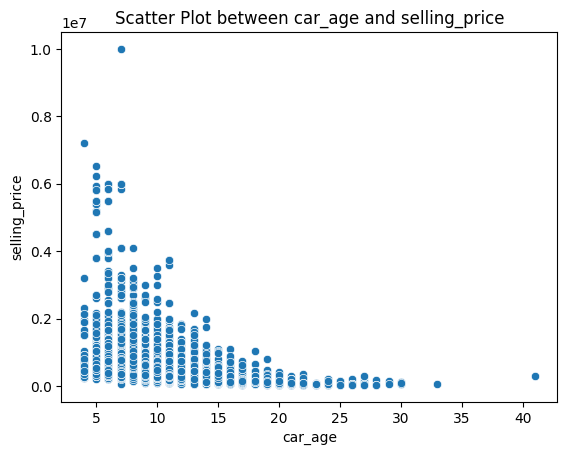

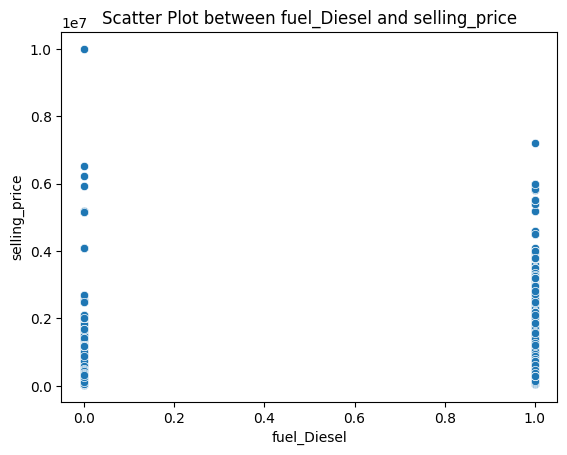

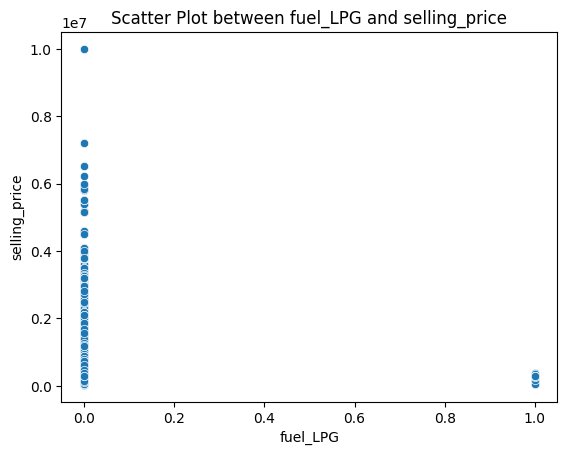

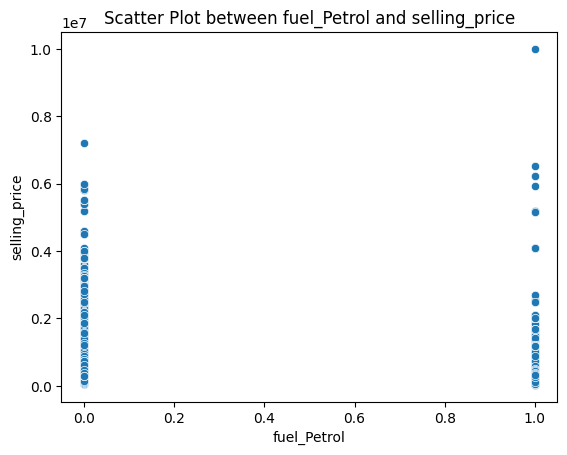

In [174]:
for column in data_new.columns:
    sns.scatterplot(data=data_new, x=column, y='selling_price')
    plt.title(f"Scatter Plot between {column} and selling_price")
    plt.show()

In [175]:
data.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,car_brand_name,car_age
0,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,5.0,Maruti,10
1,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0,Skoda,10
2,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,5.0,Honda,18
3,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,5.0,Hyundai,14
4,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,5.0,Maruti,17


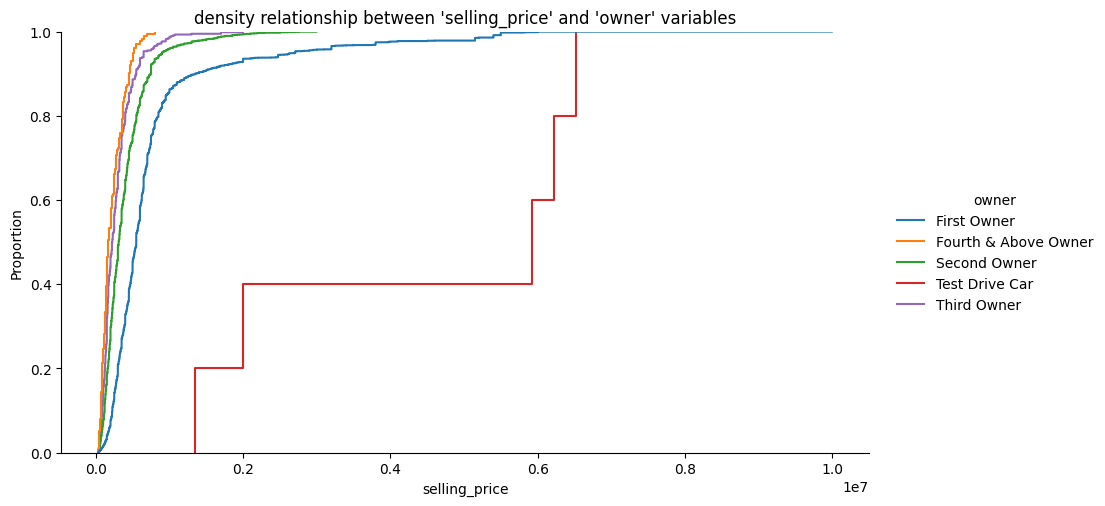

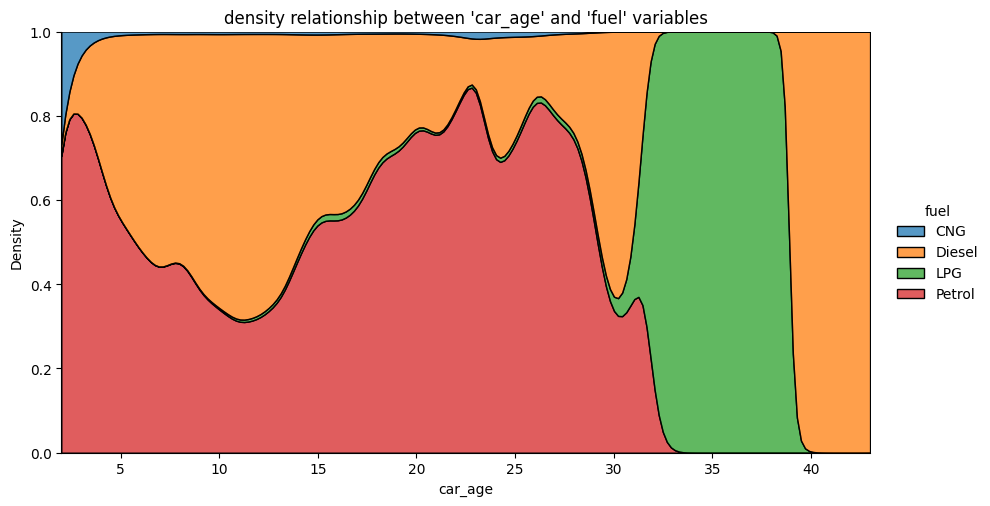

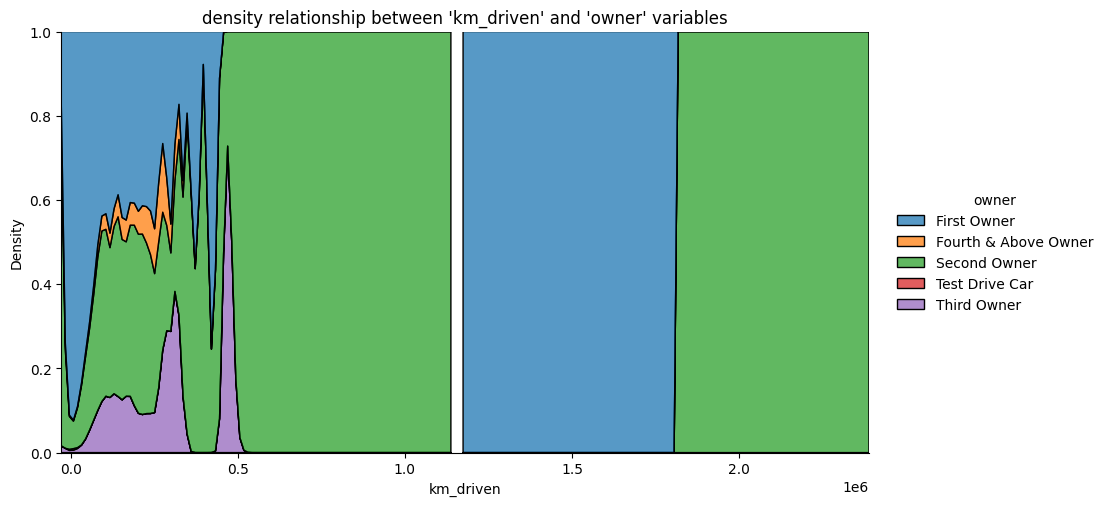

In [176]:
sns.displot(
    data = data, x = "selling_price", hue = "owner",
    kind = "ecdf", height = 5, aspect = 1.8).set(title =  "density relationship between 'selling_price' and 'owner' variables");

sns.displot(
    data = data, x = "car_age", hue = "fuel",
    kind = "kde", height = 5, aspect = 1.8, multiple="fill").set(title = "density relationship between 'car_age' and 'fuel' variables");

sns.displot(
    data = data, x = "km_driven", hue = "owner",
    kind = "kde", height = 5, aspect = 1.8, multiple="fill").set(title = "density relationship between 'km_driven' and 'owner' variables")

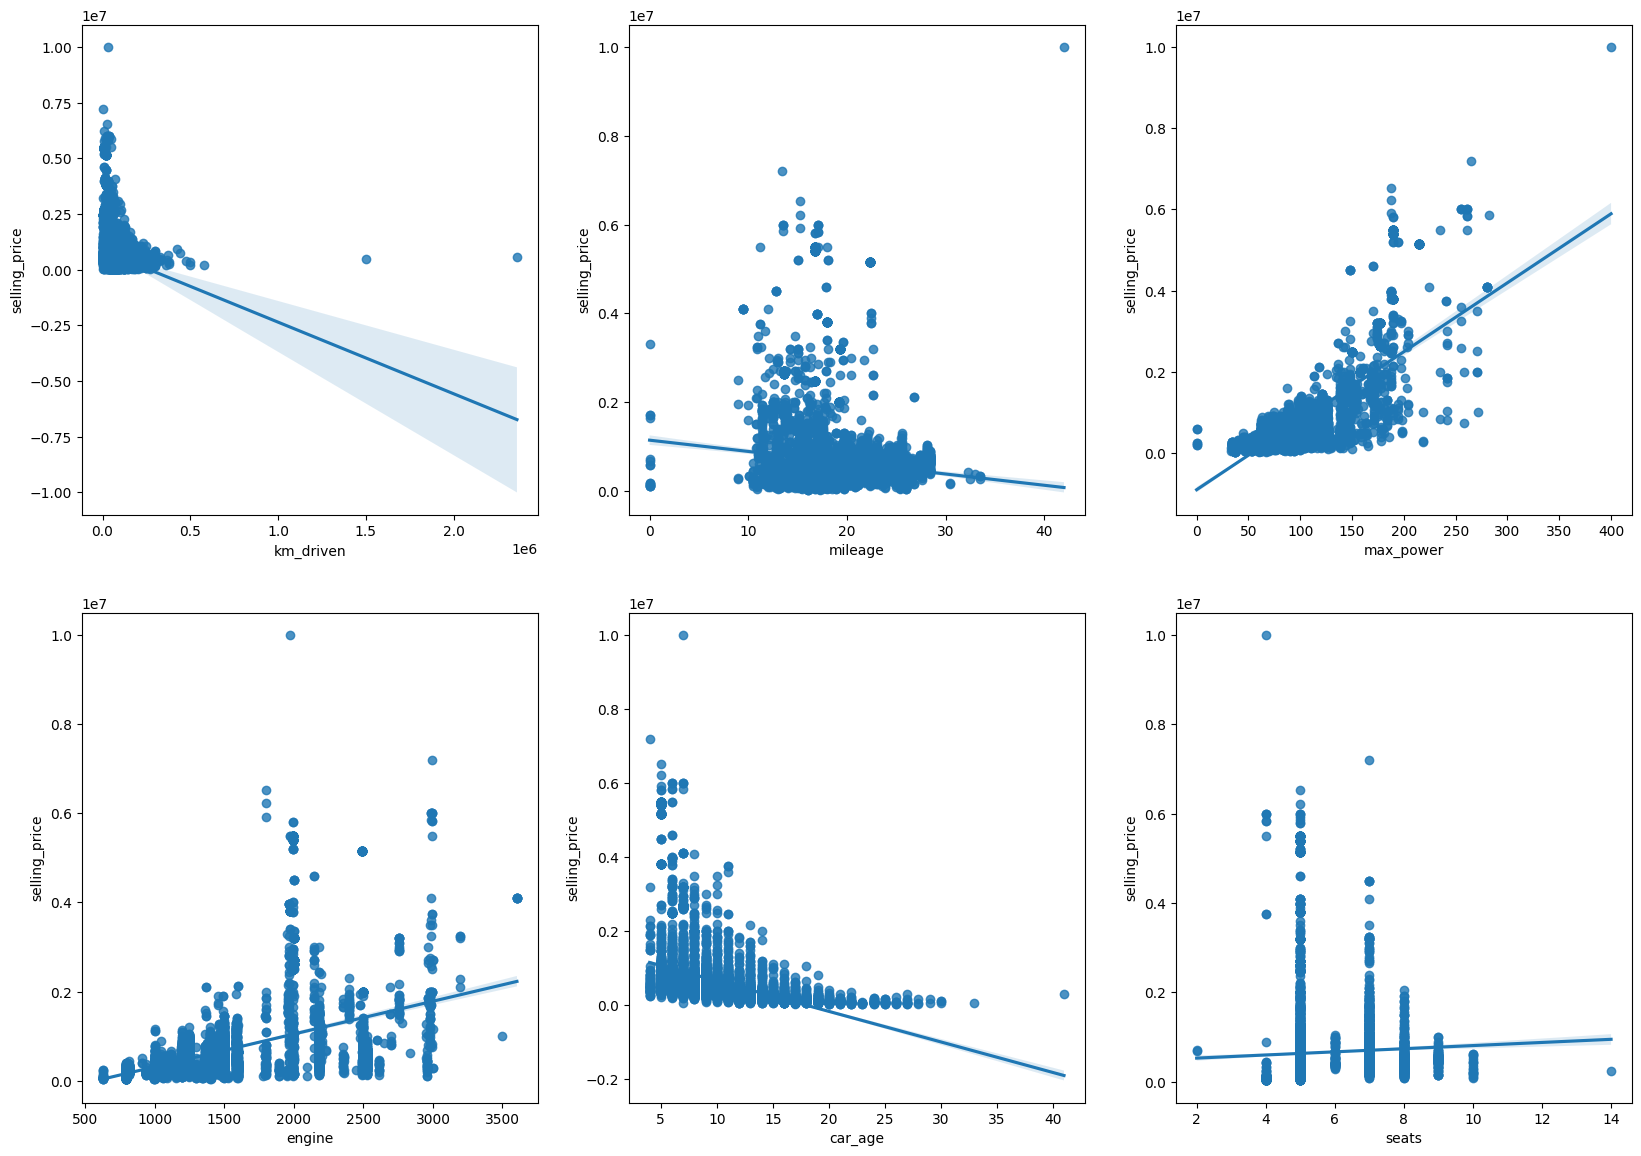

In [177]:
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.flatten()

sns.regplot(ax = axes[0], x = "km_driven", y = "selling_price", data = data);
sns.regplot(ax = axes[1], x = "mileage", y = "selling_price", data = data);
sns.regplot(ax = axes[2], x = "max_power", y = "selling_price", data = data);
sns.regplot(ax = axes[3], x = "engine", y = "selling_price", data = data);
sns.regplot(ax = axes[4], x = "car_age", y = "selling_price", data = data);
sns.regplot(ax = axes[5], x = "seats", y = "selling_price", data = data);